In [13]:
import tensorboard
%load_ext tensorboard
%tensorboard --logdir 'logs/'
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.preprocessing import KBinsDiscretizer
# Se importan librerías para graficar.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from keras import backend as K
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input
import keras.regularizers
from tensorflow.keras import optimizers
from sklearn.preprocessing import PolynomialFeatures

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 17008), started 9:04:57 ago. (Use '!kill 17008' to kill it.)

In [14]:
df = pd.read_csv('diabetes.csv')

In [15]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [16]:
healthy_people_num = (df['Outcome'] == 0).sum()
sick_people_num = (df['Outcome'] != 0).sum()
total = df.shape[0]
print("Healthy people: " + str(healthy_people_num))
print("Sick people: " + str(sick_people_num))
print("Total: " + str(total))

Healthy people: 500
Sick people: 268
Total: 768


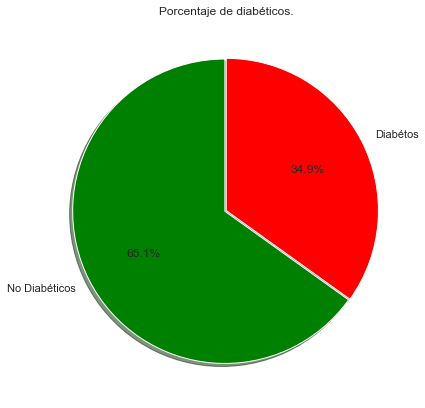

In [17]:
sns.set(style="whitegrid")
labels = ['No Diabéticos', 'Diabétos']
sizes = [healthy_people_num,sick_people_num]
colors = ["green","red"]
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, explode= (0.01,0) , colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('Porcentaje de diabéticos.')
plt.show()

In [18]:
df2 = df.copy()
df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

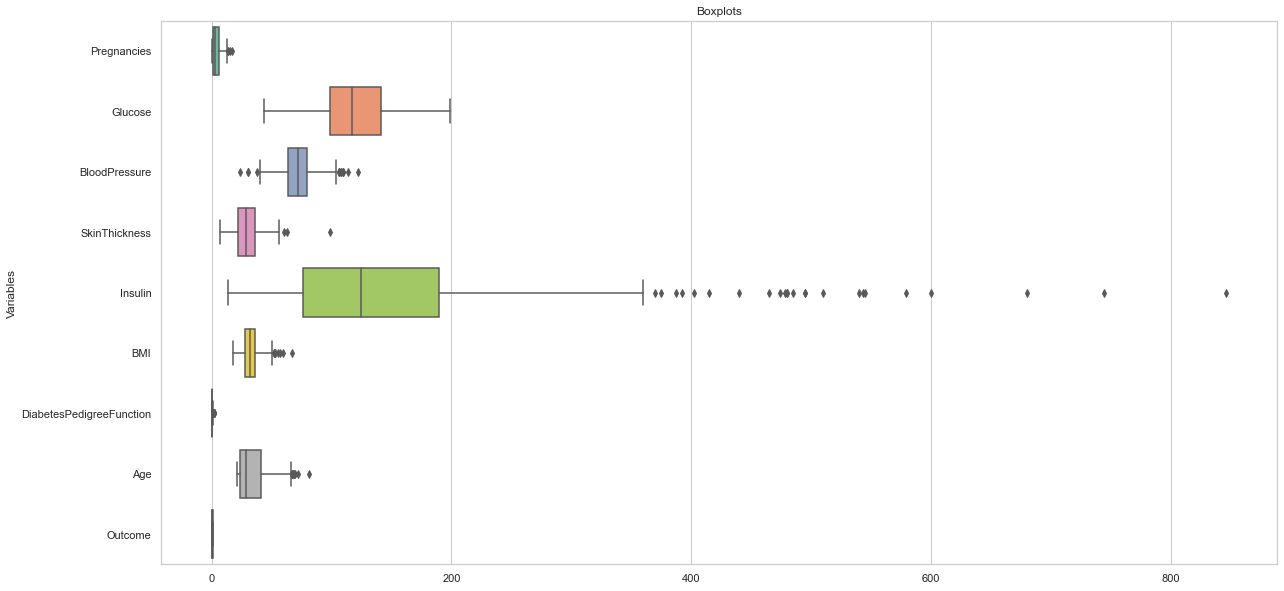

In [19]:
f, ax = plt.subplots(figsize=(20, 10))
plt.ylabel('Variables')
plt.title("Boxplots")
ax = sns.boxplot(data = df2, 
  orient = 'h', 
  palette = 'Set2')

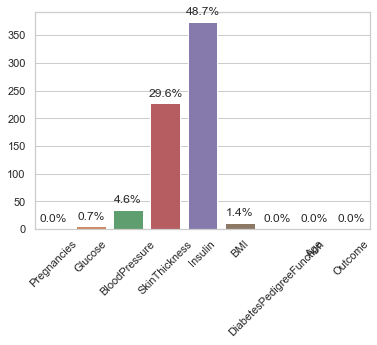

In [20]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=df2.columns, y=df2.isnull().sum())
plt.xticks(rotation=45);
for p in ax.patches:
    ax.annotate(format(100*p.get_height()/df.shape[0], '.1f') + "%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')

In [21]:
correlations = df2.corr()
correlations['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.494650
BMI                         0.313680
Insulin                     0.303454
SkinThickness               0.259491
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
BloodPressure               0.170589
Name: Outcome, dtype: float64

In [22]:
df = df.drop(['Insulin'], axis=1)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,33.6,0.627,50,1
1,1,85,66,29,26.6,0.351,31,0
2,8,183,64,0,23.3,0.672,32,1
3,1,89,66,23,28.1,0.167,21,0
4,0,137,40,35,43.1,2.288,33,1


In [23]:
msk = np.random.rand(len(df)) < 0.9
train_df = df[msk]
test_df = df[~msk]

In [24]:
def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sens_keras = true_positives / (possible_positives + K.epsilon())
    return sens_keras

def positive_predictive_value(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    ppv_keras = true_positives / (predicted_positives + K.epsilon())
    return ppv_keras

In [25]:
def plot_loss(history):
    # Plot the training loss.
    plt.plot(history.history['loss'], 'r-')

    # Plot the validation loss.
    plt.plot(history.history['val_loss'], 'b-')

    # X-axis label.
    plt.xlabel('Epochs')

    # Y-axis label.
    plt.ylabel('Cost')

    # Graph legend.
    plt.legend(["Training loss", "Validation loss"])

    # Graph title.
    plt.title('Loss Graph')

    plt.show()

In [91]:
class DiabetesPredictor:
    def __init__(self, dataframe, name, replaceOutliers=False, deleteRowsWithOutliers=False, replaceNulls=False,deleteRowsWithNulls=False, nullColumns=[], outliersColumns=[], columnsToRemove=[], polyFeatDeg = -1, binsDiscretizer = -1):
        """DiabetesPredictor

    This is a class contains the most part of the methods needed for the diabetes predictor,
    first get the data of the csv file and then perform some methods to clean the data insid
    and allows you to choose if it has to replace outliers or not and replace nulls values or not.

    """
        self.df = dataframe.copy()
        self.name = name

        nullCols = nullColumns.copy()
        outlierCols = outliersColumns.copy()

        self.__remove_columns__(columnsToRemove)
        
        nullCols = [n for n in nullColumns if n not in columnsToRemove]
        outlierCols = [out for out in outliersColumns if out[0] not in columnsToRemove]

        if (replaceNulls or deleteRowsWithNulls):
            self.df[nullCols] = self.df[nullCols].replace(0,np.NaN)

        if(replaceOutliers):
            self.__replace_outliers__(outlierCols)
        elif(deleteRowsWithOutliers): 
            self.__delete_row_with_outliers__(outlierCols)

        if(replaceNulls):
            self.__replace_nulls__(nullCols)
        elif (deleteRowsWithNulls):
            self.__delete_row_with_nulls__(nullCols)

        self.__separate_data_and_labels__()

        if (polyFeatDeg > 0):
            poly = PolynomialFeatures(degree=polyFeatDeg)
            self.x = poly.fit_transform(self.x)

        if (binsDiscretizer > 1):
            disc = KBinsDiscretizer(n_bins=binsDiscretizer, encode='ordinal', strategy='uniform')
            self.x = disc.fit_transform(self.x)

        self.__normalize_data__()
        self.__split_train_val__()

    def __separate_data_and_labels__(self):
        df_values = self.df.values
        self.x = df_values[:,:-1]
        self.y = df_values[:, -1].reshape(self.x.shape[0], 1)

    def __normalize_data__(self):
        # Mean, columnar axis.
        
        x_mean = np.mean(self.x, axis=0, keepdims=True)
        # Std. Deviation, columnar axis.
        x_std = np.std(self.x, axis=0, keepdims=True)
        
        with np.errstate(divide='ignore'):
            self.x = (self.x - x_mean)/x_std
        self.x[np.isnan(self.x)] = 0

    def __replace_outliers__(self, cols):
        #Para cada columna (excepto para el Outcome) se reemplazan los outliers por su mediana.
        if(cols == []):
            for col in self.df.columns:
                cols.append([col, np.Infinity, 0])
        for col in cols:
            Upper_val, Lower_val, med = self.__get_outliers_limits__(col)
            #Reemplazo.
            for i in self.df[col[0]]:
                if i > Upper_val or i < Lower_val:
                    self.df[col[0]] = self.df[col[0]].replace(i, med)

    def __get_outliers_limits__(self, col, want_med = True):
        #Cálculo de parámetros para obtener los outliers.
        q1 = self.df[col[0]].quantile(0.25)
        q3 = self.df[col[0]].quantile(0.75)
        iqr = q3-q1
        #Límites de los valores tipicos.
        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr

        Lower_val = min(Lower_tail, col[1])
        Upper_val = max(Upper_tail, col[2])
        #Cálculo de la mediana.
        med = np.median(self.df[col[0]])
        if(want_med == True):
            return Upper_val, Lower_val, med
        else:
            return Upper_val, Lower_val

    def __replace_nulls__(self, cols):
        columns = cols
        median=self.df[columns].median()
        self.df[columns]=self.df[columns].replace(np.NaN,median)

    def __remove_columns__(self, cols):
        self.df = self.df.drop(cols, axis=1)
    
    def __split_train_val__(self):
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.x, self.y, test_size=0.1, random_state=5)

    def __model_builder__(self,hp):
        model = Sequential()
        initializer = tf.keras.initializers.GlorotNormal(seed=7)
        model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid', input_shape=(self.x.shape[1],)))

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_momentum = hp.Choice('momentum',values=[0.9, 0.99, 0.999])
        hp_learning_rate = hp.Float('learning_rate', 1e-5, 1.0, sampling='log', default=1e-3)
        

        model.compile(optimizer=optimizers.SGD(momentum=hp_momentum, learning_rate=hp_learning_rate, ),
                        loss=keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.AUC()])

        return model

    def __find_best_hyperparams__(self):
        log_dir = "logs/" + datetime.datetime.now().strftime("%m%d-%H%M")
        hist_callback = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,
            embeddings_freq=1,
            write_graph=True,
            update_freq='batch')
        self.tuner = kt.Hyperband(self.__model_builder__,
                     kt.Objective("val_loss", direction="min"),
                     max_epochs=20,
                     factor=3,
                     executions_per_trial=3,
                     project_name=self.name,
                     directory='saved_models'
                     )
        self.tuner.search(self.x_train, self.y_train, epochs=100, validation_data = (self.x_val, self.y_val), use_multiprocessing=True)
        self.best_hps=self.tuner.get_best_hyperparameters(num_trials=2)[0]

    def get_best_hyperparams(self):
        return 'Learning Rate: ' + str(self.best_hps.get('learning_rate')) + '   --   Momentum: ' + str(self.best_hps.get('momentum'))

    def train_model(self):
        self.__find_best_hyperparams__()
        model = self.tuner.hypermodel.build(self.best_hps)
        history = model.fit(self.x_train, self.y_train, epochs=100, validation_data = (self.x_val, self.y_val), verbose=0)
        plot_loss(history)
        val_acc_per_epoch = history.history['val_loss']
        best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
        print('Best epoch: %d' % (best_epoch,))
        #plot_loss(history)
        self.hypermodel = self.tuner.hypermodel.build(self.best_hps)
        # Retrain the model
        self.hypermodel.fit(self.x_train, self.y_train, epochs=best_epoch, validation_data = (self.x_val, self.y_val))

    def validate_model(self):
        self.predictions = self.hypermodel(self.x_val)
        self.fpr_keras, self.tpr_keras, self.thresholds_keras = roc_curve(self.y_val, self.predictions)
        self.auc_keras = auc(self.fpr_keras, self.tpr_keras)
        return self.auc_keras

    def plot_roc(self):
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(self.fpr_keras, self.tpr_keras, label='Keras (area = {:.3f})'.format(self.auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()

    def get_metrics(self):
        print('AUC ' + str(self.auc_keras))
        rounded_preds = np.rint(self.predictions)
        print('Specificity: ' + str(specificity(self.y_val.astype(float),  rounded_preds.astype(float))))
        print('Sensitivity: ' + str(sensitivity(self.y_val.astype(float),  rounded_preds.astype(float))))
        print('Positive Predictive Value: ' + str(positive_predictive_value(self.y_val.astype(float), rounded_preds.astype(float))))
        print('Negative Predictive Value: ' + str(negative_predictive_value(self.y_val.astype(float), rounded_preds.astype(float))))
    
    def __delete_row_with_outliers__(self, cols):
        #Para cada columna (excepto para el Outcome) se buscan los outliers para borrar la fila
        if(cols == []):
            for col in self.df.columns:
                cols.append([col, np.Infinity, 0])
        for col in cols:
            Upper_val, Lower_val, med = self.__get_outliers_limits__(col)
            self.df = self.df[(Lower_val < self.df[col[0]]) & (self.df[col[0]] < Upper_val)]

    def __delete_row_with_nulls__(self, cols):
        for col in cols:
            self.df = self.df[pd.notnull(self.df[col])]
        

In [27]:
predictor = DiabetesPredictor(train_df,'predictor')

Trial 30 Complete [00h 00m 10s]
val_loss: 1.348380446434021

Best val_loss So Far: 0.5226732889811198
Total elapsed time: 00h 03m 11s
INFO:tensorflow:Oracle triggered exit


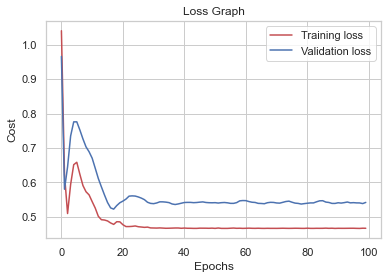

Best epoch: 18
Epoch 1/18
19/19 [==============================] - 1s 17ms/step - loss: 1.0427 - auc: 0.3901 - val_loss: 0.9513 - val_auc: 0.4180
Epoch 2/18
19/19 [==============================] - 0s 2ms/step - loss: 0.6199 - auc: 0.7176 - val_loss: 0.5807 - val_auc: 0.7451
Epoch 3/18
19/19 [==============================] - 0s 2ms/step - loss: 0.5213 - auc: 0.8273 - val_loss: 0.6517 - val_auc: 0.7925
Epoch 4/18
19/19 [==============================] - 0s 3ms/step - loss: 0.5969 - auc: 0.8226 - val_loss: 0.7400 - val_auc: 0.8043
Epoch 5/18
19/19 [==============================] - 0s 3ms/step - loss: 0.6544 - auc: 0.8193 - val_loss: 0.7755 - val_auc: 0.8039
Epoch 6/18
19/19 [==============================] - 0s 3ms/step - loss: 0.6534 - auc: 0.8243 - val_loss: 0.7708 - val_auc: 0.8098
Epoch 7/18
19/19 [==============================] - 0s 3ms/step - loss: 0.6209 - auc: 0.8323 - val_loss: 0.7520 - val_auc: 0.8088
Epoch 8/18
19/19 [==============================] - 0s 3ms/step - loss: 0.

In [28]:
predictor.train_model()

In [29]:
predictor.get_best_hyperparams()

'Learning Rate: 0.00620136356130803   --   Momentum: 0.99'

In [30]:
auc_pred = predictor.validate_model()
print('AUC: ' + str(auc_pred))

AUC: 0.7826086956521738


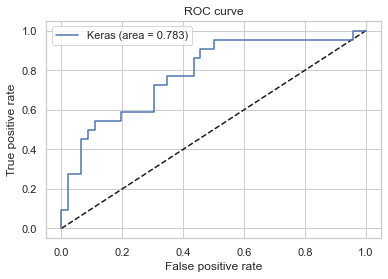

In [31]:
predictor.plot_roc()

In [32]:
predictor.get_metrics()

AUC 0.7826086956521738
Specificity: tf.Tensor(0.8913043458884687, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.5454545429752066, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7058823487889273, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8039215670511342, shape=(), dtype=float64)


## Limpiando Datos
#### Reemplazando Nulls por la mediana

Trial 30 Complete [00h 00m 10s]
val_loss: 0.5506434241930643

Best val_loss So Far: 0.46374912063280743
Total elapsed time: 00h 02m 54s
INFO:tensorflow:Oracle triggered exit


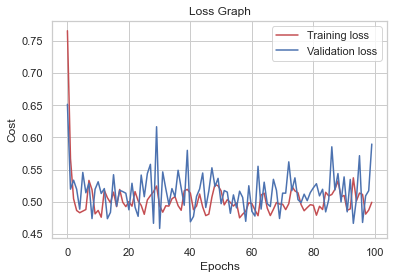

Best epoch: 31
Epoch 1/31
19/19 [==============================] - 1s 23ms/step - loss: 0.7118 - auc: 0.7545 - val_loss: 0.6232 - val_auc: 0.8335
Epoch 2/31
19/19 [==============================] - 0s 3ms/step - loss: 0.5218 - auc: 0.8192 - val_loss: 0.5121 - val_auc: 0.8231
Epoch 3/31
19/19 [==============================] - 0s 3ms/step - loss: 0.5229 - auc: 0.8096 - val_loss: 0.5982 - val_auc: 0.8231
Epoch 4/31
19/19 [==============================] - 0s 3ms/step - loss: 0.5106 - auc: 0.8235 - val_loss: 0.5475 - val_auc: 0.8192
Epoch 5/31
19/19 [==============================] - 0s 3ms/step - loss: 0.5038 - auc: 0.8233 - val_loss: 0.4742 - val_auc: 0.8444
Epoch 6/31
19/19 [==============================] - 0s 3ms/step - loss: 0.4806 - auc: 0.8375 - val_loss: 0.4970 - val_auc: 0.8177
Epoch 7/31
19/19 [==============================] - 0s 6ms/step - loss: 0.5023 - auc: 0.8276 - val_loss: 0.4680 - val_auc: 0.8463
Epoch 8/31
19/19 [==============================] - 0s 4ms/step - loss: 0.

In [33]:
predictorRepNulls = DiabetesPredictor(train_df,'rep_nulls_predictor' ,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'])
predictorRepNulls.train_model()
aucRepNulls = predictorRepNulls.validate_model()
print('AUC: ' + str(aucRepNulls))

In [34]:
predictorRepNulls.get_best_hyperparams()

'Learning Rate: 0.36880400213307357   --   Momentum: 0.9'

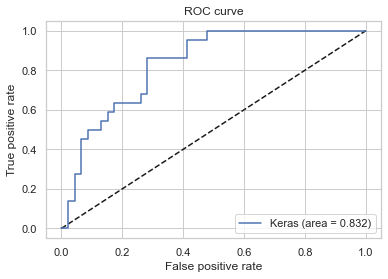

AUC 0.8320158102766799
Specificity: tf.Tensor(0.8260869547258979, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.6363636334710744, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6363636334710744, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8260869547258979, shape=(), dtype=float64)


In [35]:
predictorRepNulls.plot_roc()
predictorRepNulls.get_metrics()

#### Removiendo Nulls

Trial 30 Complete [00h 00m 08s]
val_loss: 0.4563186268011729

Best val_loss So Far: 0.4494011203447978
Total elapsed time: 00h 03m 03s
INFO:tensorflow:Oracle triggered exit


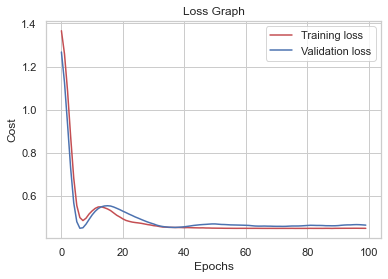

Best epoch: 7
Epoch 1/7
14/14 [==============================] - 1s 25ms/step - loss: 1.3651 - auc: 0.2932 - val_loss: 1.2699 - val_auc: 0.3619
Epoch 2/7
14/14 [==============================] - 0s 3ms/step - loss: 1.2605 - auc: 0.3094 - val_loss: 1.1191 - val_auc: 0.3893
Epoch 3/7
14/14 [==============================] - 0s 3ms/step - loss: 1.0773 - auc: 0.3517 - val_loss: 0.9199 - val_auc: 0.4500
Epoch 4/7
14/14 [==============================] - 0s 3ms/step - loss: 0.8697 - auc: 0.4441 - val_loss: 0.7168 - val_auc: 0.5798
Epoch 5/7
14/14 [==============================] - 0s 3ms/step - loss: 0.6819 - auc: 0.6247 - val_loss: 0.5636 - val_auc: 0.7679
Epoch 6/7
14/14 [==============================] - 0s 3ms/step - loss: 0.5586 - auc: 0.7776 - val_loss: 0.4780 - val_auc: 0.8321
Epoch 7/7
14/14 [==============================] - 0s 4ms/step - loss: 0.5016 - auc: 0.8328 - val_loss: 0.4490 - val_auc: 0.8357
AUC: 0.8357142857142857


In [36]:
predictorRemNulls = DiabetesPredictor(train_df,'rem_nulls_predictor' ,deleteRowsWithNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'])
predictorRemNulls.train_model()
aucRemNulls = predictorRemNulls.validate_model()
print('AUC: ' + str(aucRemNulls))

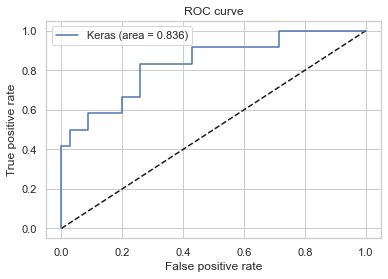

AUC 0.8357142857142857
Specificity: tf.Tensor(0.8285714262040816, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.5833333284722223, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.5384615343195267, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8529411739619377, shape=(), dtype=float64)


In [37]:
predictorRemNulls.plot_roc()
predictorRemNulls.get_metrics()

#### Removiendo Outliers

Trial 30 Complete [00h 00m 09s]
val_loss: 0.3876812358697255

Best val_loss So Far: 0.32724061608314514
Total elapsed time: 00h 03m 08s
INFO:tensorflow:Oracle triggered exit


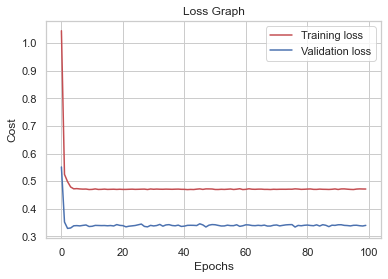

Best epoch: 3
Epoch 1/3
13/13 [==============================] - 1s 31ms/step - loss: 1.0479 - auc: 0.3897 - val_loss: 0.5791 - val_auc: 0.7426
Epoch 2/3
13/13 [==============================] - 0s 3ms/step - loss: 0.5128 - auc: 0.8173 - val_loss: 0.3515 - val_auc: 0.8946
Epoch 3/3
13/13 [==============================] - 0s 3ms/step - loss: 0.4994 - auc: 0.8332 - val_loss: 0.3270 - val_auc: 0.9105
AUC: 0.9093137254901961


In [38]:
predictorRemOutliers = DiabetesPredictor(train_df,'rem_outliers_predictor' ,deleteRowsWithNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]])
predictorRemOutliers.train_model()
aucRemOut = predictorRemOutliers.validate_model()
print('AUC: ' + str(aucRemOut))

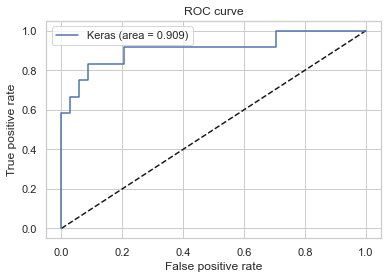

AUC 0.9093137254901961
Specificity: tf.Tensor(0.9411764678200691, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.74999999375, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.8181818107438018, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.9142857116734694, shape=(), dtype=float64)


In [39]:
predictorRemOutliers.plot_roc()
predictorRemOutliers.get_metrics()

#### Reemplazando Outliers


Trial 30 Complete [00h 00m 08s]
val_loss: 0.5842699805895487

Best val_loss So Far: 0.4302186568578084
Total elapsed time: 00h 02m 53s
INFO:tensorflow:Oracle triggered exit


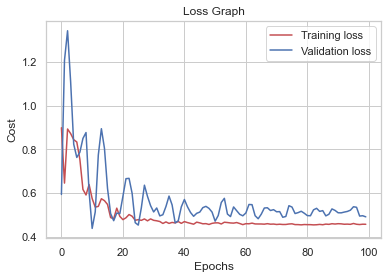

Best epoch: 11
Epoch 1/11
13/13 [==============================] - 1s 28ms/step - loss: 0.9128 - auc: 0.4973 - val_loss: 0.6246 - val_auc: 0.8571
Epoch 2/11
13/13 [==============================] - 0s 3ms/step - loss: 0.5877 - auc: 0.8328 - val_loss: 1.1190 - val_auc: 0.8643
Epoch 3/11
13/13 [==============================] - 0s 3ms/step - loss: 0.8393 - auc: 0.8213 - val_loss: 1.2185 - val_auc: 0.8393
Epoch 4/11
13/13 [==============================] - 0s 3ms/step - loss: 0.8328 - auc: 0.8226 - val_loss: 0.9863 - val_auc: 0.8405
Epoch 5/11
13/13 [==============================] - 0s 3ms/step - loss: 0.8137 - auc: 0.8274 - val_loss: 0.7782 - val_auc: 0.8048
Epoch 6/11
13/13 [==============================] - 0s 4ms/step - loss: 0.7870 - auc: 0.8323 - val_loss: 0.7317 - val_auc: 0.7976
Epoch 7/11
13/13 [==============================] - 0s 3ms/step - loss: 0.6732 - auc: 0.8304 - val_loss: 0.7885 - val_auc: 0.8107
Epoch 8/11
13/13 [==============================] - 0s 3ms/step - loss: 0.

In [40]:
predictorRepOutliers = DiabetesPredictor(train_df,'rep_outliers_predictor' ,deleteRowsWithNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], replaceOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120], ['Pregnancies',np.Infinity,0]])
predictorRepOutliers.train_model()
aucRepOut = predictorRepOutliers.validate_model()
print('AUC: ' + str(aucRepOut))

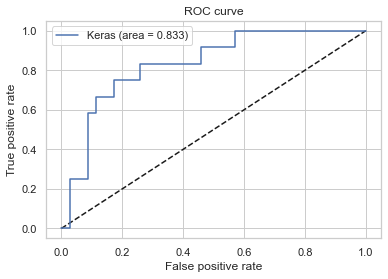

AUC 0.8333333333333333
Specificity: tf.Tensor(0.9142857116734694, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.4999999958333334, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6666666592592594, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8421052609418282, shape=(), dtype=float64)


In [41]:
predictorRepOutliers.plot_roc()
predictorRepOutliers.get_metrics()

#### Removiendo Columnas

Trial 30 Complete [00h 00m 11s]
val_loss: 1.0967126687367756

Best val_loss So Far: 0.4356391131877899
Total elapsed time: 00h 03m 00s
INFO:tensorflow:Oracle triggered exit


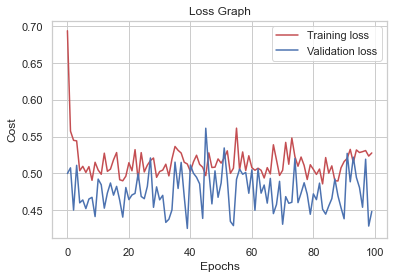

Best epoch: 40
Epoch 1/40
20/20 [==============================] - 1s 16ms/step - loss: 0.7136 - auc: 0.7577 - val_loss: 0.5473 - val_auc: 0.8159
Epoch 2/40
20/20 [==============================] - 0s 2ms/step - loss: 0.5395 - auc: 0.8058 - val_loss: 0.4425 - val_auc: 0.8474
Epoch 3/40
20/20 [==============================] - 0s 2ms/step - loss: 0.5262 - auc: 0.7993 - val_loss: 0.4399 - val_auc: 0.8497
Epoch 4/40
20/20 [==============================] - 0s 2ms/step - loss: 0.5099 - auc: 0.8161 - val_loss: 0.4542 - val_auc: 0.8302
Epoch 5/40
20/20 [==============================] - 0s 3ms/step - loss: 0.4954 - auc: 0.8271 - val_loss: 0.4845 - val_auc: 0.7890
Epoch 6/40
20/20 [==============================] - 0s 3ms/step - loss: 0.5075 - auc: 0.8098 - val_loss: 0.4524 - val_auc: 0.8391
Epoch 7/40
20/20 [==============================] - 0s 2ms/step - loss: 0.5090 - auc: 0.8122 - val_loss: 0.4630 - val_auc: 0.8177
Epoch 8/40
20/20 [==============================] - 0s 3ms/step - loss: 0.

In [42]:
bestAuc = aucRemOut
tryRemovingCols = ['BloodPressure', 'Age', 'DiabetesPedigreeFunction', 'Pregnancies', 'SkinThickness']
removeCols = []
removeColsAuc = []
nullCols = ['Glucose','BloodPressure','SkinThickness','BMI']

for col in tryRemovingCols:
	print(col)
	pred = DiabetesPredictor(df, col, deleteRowsWithNulls=True, nullColumns=nullCols, columnsToRemove=[col], deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]])
	pred.train_model()
	aucR = pred.validate_model()
	if (aucR>bestAuc):
		removeCols.append(col)
		removeColsAuc.append(aucR)



In [44]:
print(removeCols)
print(removeColsAuc)

['Age', 'DiabetesPedigreeFunction']
[0.9176470588235294, 0.934453781512605]


Trial 30 Complete [00h 00m 07s]
val_loss: 0.3259044587612152

Best val_loss So Far: 0.3158206840356191
Total elapsed time: 00h 03m 00s
INFO:tensorflow:Oracle triggered exit


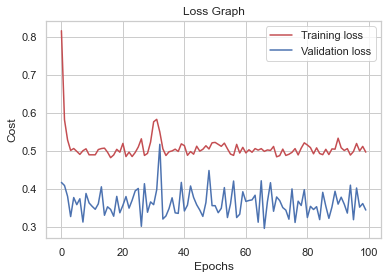

Best epoch: 67
Epoch 1/67
15/15 [==============================] - 1s 21ms/step - loss: 0.8258 - auc: 0.6925 - val_loss: 0.3498 - val_auc: 0.9286
Epoch 2/67
15/15 [==============================] - 0s 3ms/step - loss: 0.5741 - auc: 0.8102 - val_loss: 0.3668 - val_auc: 0.8958
Epoch 3/67
15/15 [==============================] - 0s 3ms/step - loss: 0.5077 - auc: 0.7971 - val_loss: 0.3344 - val_auc: 0.9261
Epoch 4/67
15/15 [==============================] - 0s 3ms/step - loss: 0.5104 - auc: 0.8002 - val_loss: 0.3888 - val_auc: 0.9059
Epoch 5/67
15/15 [==============================] - 0s 3ms/step - loss: 0.5428 - auc: 0.7744 - val_loss: 0.3883 - val_auc: 0.8908
Epoch 6/67
15/15 [==============================] - 0s 3ms/step - loss: 0.5114 - auc: 0.8096 - val_loss: 0.3367 - val_auc: 0.9227
Epoch 7/67
15/15 [==============================] - 0s 3ms/step - loss: 0.4906 - auc: 0.8145 - val_loss: 0.3610 - val_auc: 0.9059
Epoch 8/67
15/15 [==============================] - 0s 3ms/step - loss: 0.

In [45]:
remColsCombPred = DiabetesPredictor(df, 'remColsComb', deleteRowsWithNulls=True, nullColumns=nullCols, columnsToRemove=removeCols, deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]])
remColsCombPred.train_model()
aucRemColsComb = remColsCombPred.validate_model()

In [46]:
print('AUC: ' + str(aucRemColsComb))

AUC: 0.9109243697478991


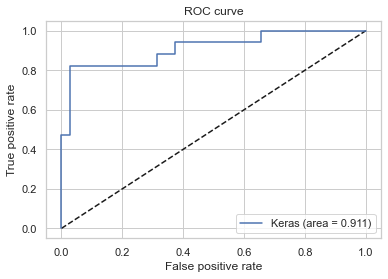

AUC 0.9109243697478991
Specificity: tf.Tensor(0.9714285686530612, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7058823487889273, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.9230769159763315, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8717948695595004, shape=(), dtype=float64)


In [47]:
remColsCombPred.plot_roc()
remColsCombPred.get_metrics()

#### Sacando solo Pedigree

Trial 30 Complete [00h 00m 08s]
val_loss: 0.34478365381558734

Best val_loss So Far: 0.316836138566335
Total elapsed time: 00h 03m 09s
INFO:tensorflow:Oracle triggered exit


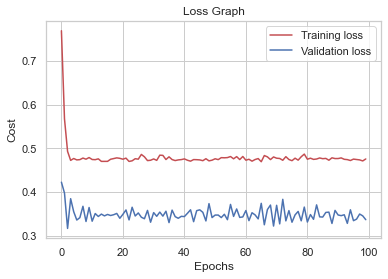

Best epoch: 3
Epoch 1/3
15/15 [==============================] - 1s 21ms/step - loss: 0.7631 - auc: 0.6559 - val_loss: 0.4168 - val_auc: 0.9042
Epoch 2/3
15/15 [==============================] - 0s 3ms/step - loss: 0.5444 - auc: 0.8151 - val_loss: 0.3672 - val_auc: 0.8941
Epoch 3/3
15/15 [==============================] - 0s 3ms/step - loss: 0.4989 - auc: 0.8171 - val_loss: 0.3278 - val_auc: 0.9244


In [49]:
remPedigreePred = DiabetesPredictor(df, 'remPedigreePred', deleteRowsWithNulls=True, nullColumns=nullCols, columnsToRemove=['DiabetesPedigreeFunction'], deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]])
remPedigreePred.train_model()
aucRemPedigree = remPedigreePred.validate_model()

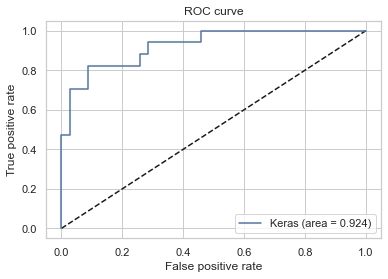

AUC 0.9243697478991597
Specificity: tf.Tensor(0.9142857116734694, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7647058778546713, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.812499994921875, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.888888886419753, shape=(), dtype=float64)


In [51]:
remPedigreePred.plot_roc()
remPedigreePred.get_metrics()

### Con PolynomialFeatures

Trial 30 Complete [00h 00m 09s]
val_loss: 0.4269460340340932

Best val_loss So Far: 0.27540063858032227
Total elapsed time: 00h 03m 00s
INFO:tensorflow:Oracle triggered exit


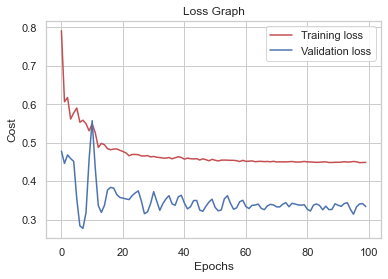

Best epoch: 8
Epoch 1/8
15/15 [==============================] - 1s 21ms/step - loss: 0.7780 - auc: 0.4870 - val_loss: 0.4872 - val_auc: 0.8924
Epoch 2/8
15/15 [==============================] - 0s 3ms/step - loss: 0.6159 - auc: 0.7878 - val_loss: 0.4384 - val_auc: 0.9084
Epoch 3/8
15/15 [==============================] - 0s 3ms/step - loss: 0.6227 - auc: 0.8194 - val_loss: 0.4623 - val_auc: 0.8966
Epoch 4/8
15/15 [==============================] - 0s 3ms/step - loss: 0.5729 - auc: 0.8194 - val_loss: 0.4674 - val_auc: 0.8689
Epoch 5/8
15/15 [==============================] - 0s 3ms/step - loss: 0.5876 - auc: 0.7707 - val_loss: 0.4855 - val_auc: 0.8294
Epoch 6/8
15/15 [==============================] - 0s 3ms/step - loss: 0.6138 - auc: 0.7293 - val_loss: 0.3841 - val_auc: 0.8647
Epoch 7/8
15/15 [==============================] - 0s 3ms/step - loss: 0.5483 - auc: 0.7942 - val_loss: 0.2955 - val_auc: 0.9210
Epoch 8/8
15/15 [==============================] - 0s 3ms/step - loss: 0.5490 - au

In [92]:
polyPred = DiabetesPredictor(df, 'featPol', deleteRowsWithNulls=True, nullColumns=nullCols, columnsToRemove=['DiabetesPedigreeFunction'], deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]], polyFeatDeg=2)
polyPred.train_model()
aucPolyPred = polyPred.validate_model()

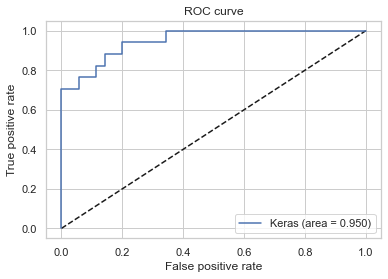

AUC 0.9495798319327731
Specificity: tf.Tensor(0.9428571401632653, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7647058778546713, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.866666660888889, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8918918894813732, shape=(), dtype=float64)


In [93]:
polyPred.plot_roc()
polyPred.get_metrics()

Trial 30 Complete [00h 00m 08s]
val_loss: 0.2687751849492391

Best val_loss So Far: 0.2687751849492391
Total elapsed time: 00h 03m 25s
INFO:tensorflow:Oracle triggered exit


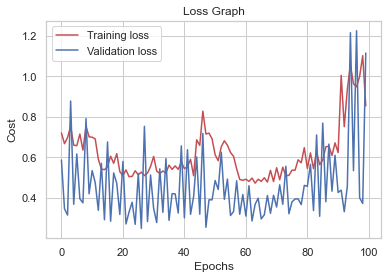

Best epoch: 27
Epoch 1/27
15/15 [==============================] - 1s 26ms/step - loss: 0.8003 - auc: 0.7140 - val_loss: 0.5048 - val_auc: 0.8849
Epoch 2/27
15/15 [==============================] - 0s 3ms/step - loss: 0.7293 - auc: 0.7342 - val_loss: 0.3906 - val_auc: 0.8798
Epoch 3/27
15/15 [==============================] - 0s 3ms/step - loss: 0.7428 - auc: 0.7848 - val_loss: 0.3214 - val_auc: 0.9479
Epoch 4/27
15/15 [==============================] - 0s 3ms/step - loss: 0.7390 - auc: 0.7541 - val_loss: 0.8466 - val_auc: 0.7496
Epoch 5/27
15/15 [==============================] - 0s 3ms/step - loss: 0.6095 - auc: 0.8104 - val_loss: 0.3434 - val_auc: 0.9134
Epoch 6/27
15/15 [==============================] - 0s 6ms/step - loss: 0.6046 - auc: 0.7780 - val_loss: 0.5522 - val_auc: 0.8336
Epoch 7/27
15/15 [==============================] - 0s 6ms/step - loss: 0.6135 - auc: 0.7787 - val_loss: 0.3993 - val_auc: 0.9218
Epoch 8/27
15/15 [==============================] - 0s 3ms/step - loss: 0.

In [94]:
polyPred3 = DiabetesPredictor(df, 'featPol3', deleteRowsWithNulls=True, nullColumns=nullCols, columnsToRemove=['DiabetesPedigreeFunction'], deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]], polyFeatDeg=2)
polyPred3.train_model()
aucPolyPred3 = polyPred3.validate_model()

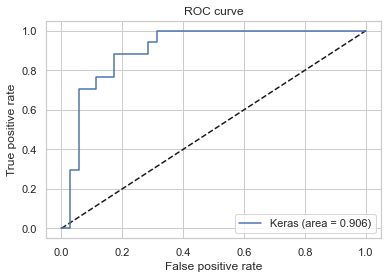

AUC 0.9058823529411765
Specificity: tf.Tensor(0.9428571401632653, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.35294117439446365, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7499999906250002, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.7499999982954545, shape=(), dtype=float64)


In [95]:
polyPred3.plot_roc()
polyPred3.get_metrics()

Trial 30 Complete [00h 00m 08s]
val_loss: 0.475899616877238

Best val_loss So Far: 0.3072708149751027
Total elapsed time: 00h 03m 14s
INFO:tensorflow:Oracle triggered exit


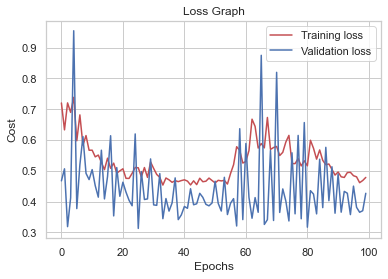

Best epoch: 26
Epoch 1/26
15/15 [==============================] - 1s 34ms/step - loss: 0.6922 - auc: 0.6824 - val_loss: 0.5019 - val_auc: 0.8908
Epoch 2/26
15/15 [==============================] - 0s 6ms/step - loss: 0.7057 - auc: 0.8165 - val_loss: 0.5041 - val_auc: 0.8597
Epoch 3/26
15/15 [==============================] - 0s 5ms/step - loss: 0.7287 - auc: 0.7116 - val_loss: 0.3380 - val_auc: 0.8824
Epoch 4/26
15/15 [==============================] - 0s 3ms/step - loss: 0.6690 - auc: 0.7924 - val_loss: 0.3634 - val_auc: 0.9143
Epoch 5/26
15/15 [==============================] - 0s 2ms/step - loss: 0.6305 - auc: 0.7861 - val_loss: 0.8639 - val_auc: 0.6504
Epoch 6/26
15/15 [==============================] - 0s 3ms/step - loss: 0.5542 - auc: 0.7977 - val_loss: 0.3692 - val_auc: 0.9193
Epoch 7/26
15/15 [==============================] - 0s 4ms/step - loss: 0.6366 - auc: 0.8170 - val_loss: 0.4239 - val_auc: 0.8849
Epoch 8/26
15/15 [==============================] - 0s 3ms/step - loss: 0.

In [96]:
polyBinsPred = DiabetesPredictor(df, 'featPolBins', deleteRowsWithNulls=True, nullColumns=nullCols, columnsToRemove=['DiabetesPedigreeFunction'], deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]], polyFeatDeg=2, binsDiscretizer=5)
polyBinsPred.train_model()
aucPolyBinsPred = polyBinsPred.validate_model()

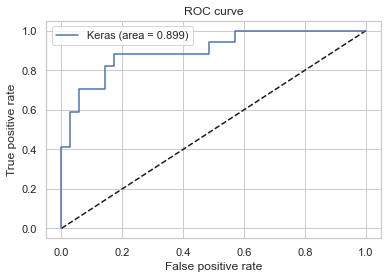

AUC 0.8991596638655461
Specificity: tf.Tensor(0.9428571401632653, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7058823487889273, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.8571428510204082, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8684210503462604, shape=(), dtype=float64)


In [97]:
polyBinsPred.plot_roc()
polyBinsPred.get_metrics()